# CC5215: Privacidad de Datos
## Laboratorio 2

**Integrantes**
- Francisco Gutiérrez Albornoz

In [298]:
# Load the data and libraries
import pandas as pd
import numpy as np

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

# Dataset with private information
adult_pii = adult[['Name', 'DOB', 'SSN', 'Zip', 'Age']]
# Deanonimized dataset
adult_deid = adult[['DOB', 'Zip', 'Age', 'Target']].dropna(subset=['Target'])

# quasi-identifiers
qis = ['Age', 'Zip']

In the previous lab, in order to achieve 5-anonimity for the dataset `adult_deid` we had to essentially either get rid of the column 'Age' or 'Zip'. This was due to the presence of outliers which, no matter how much we generalized before losing a column, they were always distinguishable from the rest of the dataset.

In this laboratory, we will use other mechanisms of generalization and anonimization of the dataset in order to achieve a certain level of $k$-anonimity without having to get rid of entire columns. Additionally, we will aim to also satisfy some level of $l$-diversity.

We will only work with the dataset `adult_deid` and measure $l$-diversity for the column 'Target'.

## Question 1 (10 points)

In the previous lab you defined a `generalize` function to mask the less-significant digits of a numeric column. Whereas it may be intuitive to generalize the column 'Zip' using this method, it is not so obvious for the column 'Age' (we only have two options: intervals of 10 or 100!). We have renamed the function `generalize` to `mask_with_zeros` and re-defined it to operate on the whole dataset.

Define a function `generalize_by_intervals` that converts a numeric column in its interval counterpart. This function should be parametrized by the size of the intervals, and assume that intervals start at zero, i.e. [0, 5), [5, 10), etc.

In [299]:
# mask_with_zeros was previously named generalize
def mask_with_zeros(df, depths):
    """
    Returns a copy of `df` where the numeric column declared in `depths` are
    generalized by replacing the least significant digits (also specified by
    `depths`) with zeros
    """
    new_df = df.copy()
    for col, depth in depths.items():
        factor = 10 ** depth
        new_df[col] = new_df[col].apply(lambda value: factor * int(value / factor))

    return new_df

In [300]:
def generalize_by_intervals(df, col, interval_size):
    """
    Returns a copy of `df` where the column 'col' is generalized in a way such
    that every value is transformed to an interval of size `interval_size`
    """
    new_df = df.copy()
    # límites de los datos
    max_value = int(new_df[col].max())
    min_value = 0 #int(new_df[col].min())
    intervals = np.arange(min_value, max_value + 2*interval_size, interval_size)
    labels = [f"[{intervals[i]}, {intervals[i+1]})" for i in range(len(intervals)-1)]
    new_df[col] = pd.cut(new_df[col], bins=intervals, labels=labels, right=False, include_lowest=True)
    return new_df

In [301]:
# adult_deid with age splitted in intervals of 5
adult_deid_gen = generalize_by_intervals(adult_deid, 'Age', 5)
assert adult_deid['Age'].nunique() == 73
# there should be only 16 possible values for 'Age'
assert adult_deid_gen['Age'].nunique() == 16

## Question 2 (5 points)

The generalization using intervals should improve the anonimity of our dataset. Plot the histogram for the column 'Age' of the datasets `adult_deid` and `adult_deid_gen` in order to observe how the distribution of values have changed.

*Hint*: use the `hist` function.





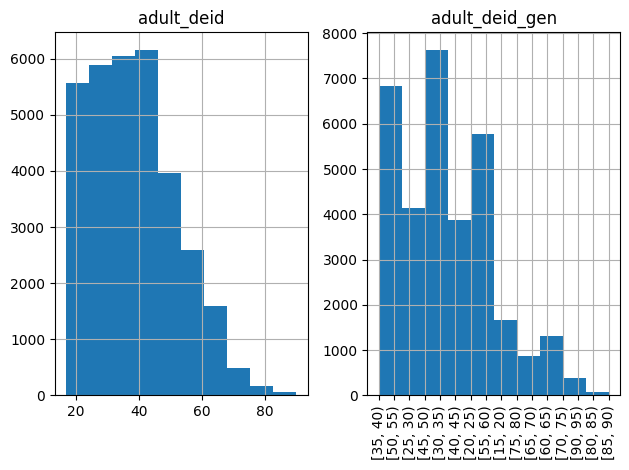

In [316]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
adult_deid['Age'].hist()
plt.title('adult_deid')
plt.subplot(1,2,2)
adult_deid_gen['Age'].hist()
plt.title('adult_deid_gen')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Do you think that generalizing by intervals will be enough to get rid of outliers?

**Respuesta**: Podría ser suficiente pero tal vez con intervalos más grandes ya que en el histograma anterior se ve que en los extremos se tiene una frecuencia muy baja.

## Question 3 (5 points)

In order to measure how good our generalizations are we need a way to compute the index of anonimity.

Define a function `compute_anonimity_index` that calculates the (greatest) $k$ for which the dataset is $k$-anonymous, namely, the anonimity index.

In [303]:
def compute_anonimity_index(df, qis):
    counts = df[qis].groupby(qis).value_counts()
    counts = counts[counts > 0]
    return counts.sort_values().min()

In [304]:
assert compute_anonimity_index(adult_deid, qis) == 1
# Test from last lab
assert compute_anonimity_index(mask_with_zeros(adult_deid, { 'Zip': 2, 'Age': 2 }), qis) >= 5

## Question 4 (10 points)

Define a function `compute_diversity_index` that calculates the $l$ for which the dataset is $l$-diverse (for distinct diversity) for a given sensitive attribute, namely, the diversity index.

*Hint*: You can use the `groupby` method for dataframes and the `nunique` method for series in order to calculate the index.

In [ ]:
def compute_diversity_index(df, qis, target):
    grouped = df.groupby(qis, observed=True)# [target].value_counts()
    l_list = []
    for _,group in grouped:
        l_list.append(group[target].nunique())
    return min(l_list)

In [306]:
adult_deid_gen = mask_with_zeros(adult_deid_gen, { 'Zip': 4 })

assert compute_diversity_index(adult_deid_gen, qis, 'Target') == 1

## Question 5 (10 points)

- Plot an histogram that illustrates the number of groups (grouped by our quasi-identifiers) vs the number of different sensitive values in each group, for the generalized dataframe.


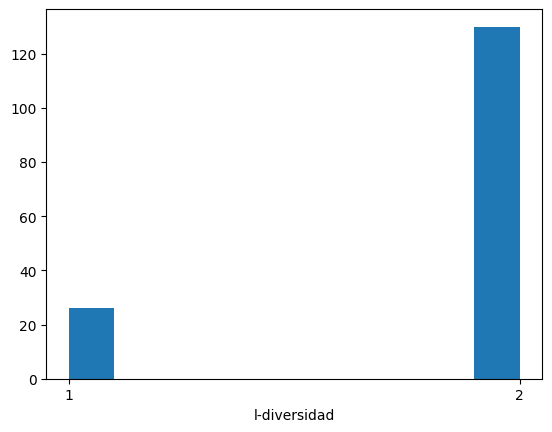

In [307]:
grouped = adult_deid_gen.groupby(qis, observed=True)["Target"].nunique()
grouped.hist()
plt.xlabel('l-diversidad')
plt.xticks([1, 2])
plt.grid()
plt.show()


- Write the code to find what rows contain only one unique sensitivity value (`'Target'`) when grouped by the quasi-identifies `['Age', 'Zip']`.

In [ ]:
def findUniques(df, qis, target):
    unique_adult_deid = df.groupby(qis, observed=True)[target].nunique()
    uniques = unique_adult_deid[unique_adult_deid==1]
    return uniques

uniques = findUniques(adult_deid_gen, qis, "Target")
uniques #valores únicos (son los que se ven en el histograma)

Age       Zip  
[15, 20)  0        1
          10000    1
          20000    1
          30000    1
          40000    1
          50000    1
          60000    1
          70000    1
[70, 75)  40000    1
[80, 85)  0        1
          30000    1
          40000    1
          60000    1
          70000    1
[85, 90)  0        1
          10000    1
          20000    1
          40000    1
          60000    1
          80000    1
[90, 95)  0        1
          10000    1
          20000    1
          30000    1
          40000    1
          50000    1
Name: Target, dtype: int64

In [339]:
def findUniquesRow(df, qis, target):
    unique_counts = df.groupby(qis, observed=True)[target].nunique()
    unique_groups = unique_counts[unique_counts == 1].index
    return df[df[qis].apply(tuple, axis=1).isin(unique_groups)]

uniques = findUniquesRow(adult_deid_gen, qis, "Target")
uniques #filas con valores únicos

,DOB,Zip,Age,Target
51,10/11/1961,60000,"[15, 20)",<=50K
70,3/20/1974,40000,"[15, 20)",<=50K
78,7/10/1954,20000,"[15, 20)",<=50K
80,2/24/1956,40000,"[15, 20)",<=50K
106,5/22/2005,60000,"[15, 20)",<=50K
...,...,...,...,...
32443,5/5/1960,0,"[15, 20)",<=50K
32447,2/4/2011,50000,"[15, 20)",<=50K
32459,7/26/2012,20000,"[85, 90)",<=50K
32494,8/25/1983,60000,"[80, 85)",<=50K


- Describe the outliers.

**Repuesta:** Los outliers en el rango [15, 20) podrían ser porque como los votantes tienen al menos 18 años, los que se encuentran en este intervalo son pocos y además con un código zip en particular son aún menos.
Para los rangos de mayor de edad podría estar relacionado con la esperanza de vida y debido a esto ya al separlos por código zip son aún menos.

## Question 6 (5 points)

- Write a function `generalize_by_bounds` that sets a lower and upper bound to a numeric column.



In [309]:
def generalize_by_bounds(df, col, lower, upper):
    """
    Creates a new dataframe from `df` where the column 'col' is
    generalized in a way such that every value below or equal to `lower` is
    replaced by `lower`, and every value above `upper` is replaced by `upper`
    """
    new_df = df.copy()
    new_df[col]=new_df.apply(lambda row: lower if row[col]<=lower else upper if row[col]>=upper else row[col], axis=1)
    return new_df

In [310]:
def generalize_by_bounds(df, col, lower, upper):
    new_df = df.copy()
    intervals = df[col].cat.categories
    # Filtramos los intervalos que estén fuera de los límites lower y upper
    new_intervals = [interval for interval in intervals if int(interval.split(',')[0][1:]) >= lower and int(interval.split(',')[1][:-1]) <= upper]
    
    # Aplicamos los intervalos filtrados
    new_df[col] = new_df[col].apply(
        lambda x: x if x in new_intervals else (
            new_intervals[0] if x < new_intervals[0] else new_intervals[-1]
        )
    )
    return new_df

- Use the `generalize_by_bounds` function to achieve 2-diversity and 41-anonimity.



In [312]:
adult_deid_2div = generalize_by_bounds(adult_deid_gen, "Age", 20, 75)

ldiv = compute_diversity_index(adult_deid_2div, qis, 'Target')
kanon = compute_anonimity_index(adult_deid_2div, qis)

assert ldiv == 2
assert kanon == 41

print("The final diversity index is:", ldiv)
print("The final anonimity index is:", kanon)

The final diversity index is: 2
The final anonimity index is: 41


- Describe using natural language the changes done to the original dataframe.

**Respuesta**: Los cambios hechos a los dataframe son agrupaciones, ya que se fijan rangos de código zip y se generalizan. Luego, se clasifican las edades por rangos para lograr anonimización y luego se generalizan sus valores para eliminar los datos que se alejan del comportamiento general (outliers) con esto se logra evitar la diferenciación de los datos.

## Question 7 (15 points)

The entropic diversity of a QID group measures how evenly the private values of some attribute $S$ are distributed in that group. It is formally defined as
$$-\sum_{v\in S}\mathtt{P}(\mathit{QIds}, v)*\mathtt{log}(\mathtt{P}(\mathit{QIds}, v))$$
where $\mathtt{P}(\mathit{QIds}, v)$ corresponds to the fraction of records in the $\mathit{QIds}$ group with value $v$ for the attribute $S$.
For example, for the following table where disease is a sensitive data:

| Job | Sex | Age | Disease |
| --- | --- | --- | --- |
| Professional | F | [35-40) | Hepatitis |
| Professional | F | [35-40) | Hepatitis |
| Professional | F | [35-40) | VIH |
| Artist | M | [35-35) | Flu |
| Artist | M | [35-35) | VIH |
| Artist | M | [35-35) | VIH |
| Artist | M | [35-35) | VIH |

The entropic diversity of the group (Professional, F, [35-40)) is $-(\frac{2}{3}\mathtt{log}\frac{2}{3} + \frac{1}{3}\mathtt{log}\frac{1}{3}) = \mathtt{log}(1.9)$, and the entropic diversity of group (Artist, M, [35-35)) is $-(\frac{3}{4}\mathtt{log}\frac{3}{4} + \frac{1}{4}\mathtt{log}\frac{1}{4}) = \mathtt{log}(1.8)$.

The entropic diversity of a table is the minimum of all the entropic diversities among all QIds.

Write a function that computes the entropic diversity of a dataframe.

Hint: Investigate what the following calls do in pandas: `...value_counts(normalize=True)` and `...reset_index(name='...')`

In [313]:
import math
def l_entropic_diversity(df, qis, target):
    """
    Computes the entropic diversity of a dataframe given the QIDs qis, and the sensitivity attribute target.
    """
    grouped = df.groupby(qis)
    H = []
    for par, group in grouped:
        p = group[target].value_counts(normalize=True)
        H.append(-np.sum(p*np.log(p)))
        
    return min(H)

assert np.isclose(l_entropic_diversity(adult_deid_2div, qis, 'Target'), 0.02490171502983102)